# Chapter 9: Hypothesis testing

In [1]:
library(tidyverse)
library(ggplot2)
library(cowplot)
set.seed(123456) # set random seed to exactly replicate results
library(knitr)
theme_set(theme_minimal(base_size = 14))

# load the NHANES data library
library(NHANES)

# drop duplicated IDs within the NHANES dataset
NHANES <-
  NHANES %>%
  dplyr::distinct(ID,.keep_all = TRUE)

NHANES_adult <-
  NHANES %>%
  drop_na(PhysActive,BMI, BPSysAve) %>%
  subset(Age >= 18)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.1     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


## Table 9.1

In [2]:
# sample 250 adults from NHANES and compute mean BP separately for active
# and inactive individuals

sampSize <- 250
set.seed(12345)
NHANES_sample <-
  NHANES_adult %>%
  mutate(HealthGenNum=recode(HealthGen, 'Poor'=1, 'Fair'=2, 'Good'=3, 'Vgood'=4, 'Excellent'=5)) %>%
  sample_n(sampSize)

sampleSummary <-
  NHANES_sample %>%
  group_by(PhysActive) %>%
  summarize(
    N = length(BPSysAve),
    mean = mean(BPSysAve),
    sd = sd(BPSysAve)
  )

# calculate the mean difference in BP between active
# and inactive individuals; we'll use this later to calculate the t-statistic
meanDiff <-
  sampleSummary %>%
  select(
    PhysActive,
    mean
  ) %>%
  spread(PhysActive, mean) %>%
  mutate(
    meanDiff = No - Yes
  ) %>%
  pull(meanDiff)

# calculate the summed variances in BP for active
# and inactive individuals; we'll use this later to calculate the t-statistic
sumVariance <-
  sampleSummary %>%
  select(
    PhysActive,
    N,
    sd
  ) %>%
  gather(column, stat, N:sd) %>%
  unite(temp, PhysActive, column) %>%
  spread(temp, stat) %>%
  mutate(
    sumVariance = No_sd**2 / No_N + Yes_sd**2 / Yes_N
  ) %>%
  pull(sumVariance)

s1 = sampleSummary$sd[1]
s2 = sampleSummary$sd[2]
n1 = sampleSummary$N[1]
n2 = sampleSummary$N[2]

welch_df = (s1/n1 + s2/n2)**2 / ((s1/n1)**2/(n1-1) + (s2/n2)**2/(n2-1))

# print sampleSummary table
kable(sampleSummary, digits=4,caption='Summary of blood pressure data for active versus inactive individuals')



Table: Summary of blood pressure data for active versus inactive individuals

|PhysActive |   N|     mean|      sd|
|:----------|---:|--------:|-------:|
|No         | 126| 123.8810| 20.8052|
|Yes        | 124| 119.3226| 17.1486|

## Figure 9.1

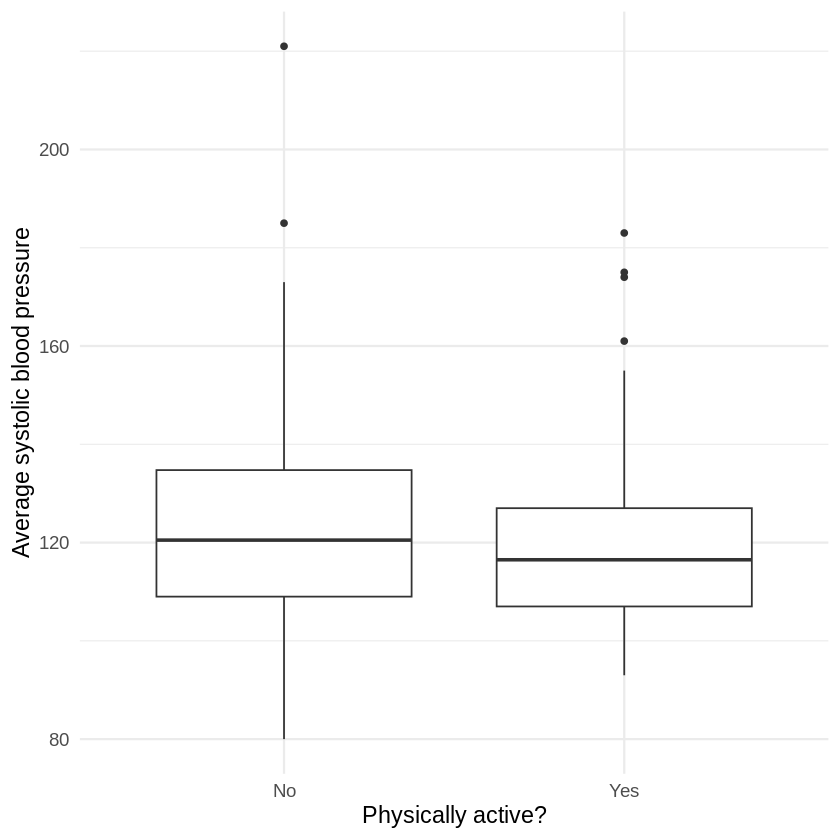

In [3]:
ggplot(NHANES_sample,aes(PhysActive,BPSysAve)) +
  geom_boxplot() +
  xlab('Physically active?') +
  ylab('Average systolic blood pressure')

## Figure 9.2

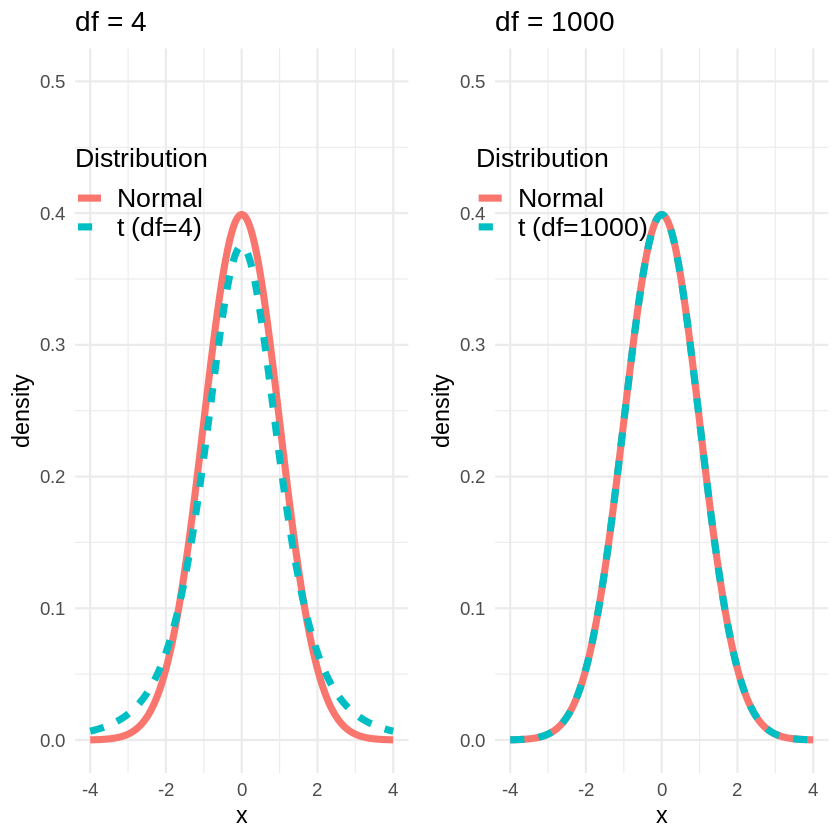

In [4]:
distDfNormal <- data.frame(x=seq(-4,4,0.01)) %>%
  mutate(normal=dnorm(x), Distribution='Normal')
distDft4 <- data.frame(x=seq(-4,4,0.01)) %>%
  mutate(normal=dt(x, df=4), Distribution='t (df=4)')
distDft1000 <- data.frame(x=seq(-4,4,0.01)) %>%
  mutate(normal=dt(x, df=1000), Distribution='t (df=1000)')

legendsize=16

p1 <- ggplot(rbind(distDfNormal, distDft4),aes(x=x, y=normal, color=Distribution)) +
  geom_line(aes(linetype=Distribution), linewidth=2) +
  ggtitle('df = 4') +
  ylab('density') +
  ylim(0, 0.5) +
  theme(text = element_text(size=14)) +
  theme(legend.position=c(0.2, 0.8),
        legend.title = element_text(size = legendsize),
        legend.text = element_text(size = legendsize)
)

p2 <-ggplot(rbind(distDfNormal, distDft1000),aes(x=x, y=normal, color=Distribution)) +
  geom_line(aes(linetype=Distribution), linewidth=2) +
  ggtitle('df = 1000') +
  ylab('density') +
  ylim(0, 0.5) +
  theme(text = element_text(size=14)) +
  theme(legend.position=c(0.2, 0.8),
        legend.title = element_text(size = legendsize),
        legend.text = element_text(size = legendsize)
)
plot_grid(p1,p2)

## Figure 9.3

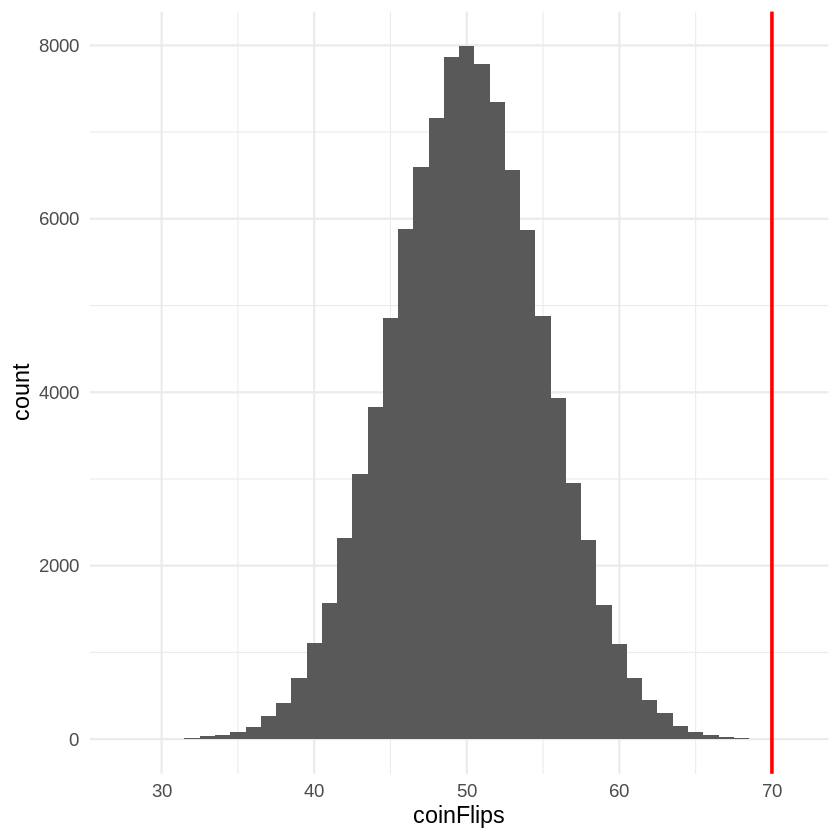

In [5]:
# simulate tossing of 100,000 flips of 100 coins to identify empirical
# probability of 70 or more heads out of 100 flips

# create function to toss coins
tossCoins <- function() {
  flips <- runif(100) > 0.5
  return(sum(flips))
}

# compute the probability of 69 or fewer heads, when P(heads)=0.5
p_lt_70 <- pbinom(69, 100, 0.5)

# the probability of 70 or more heads is simply the complement of p_lt_70
p_ge_70 <- 1 - p_lt_70

# use a large number of replications since this is fast
coinFlips <- replicate(100000, tossCoins())

p_ge_70_sim <- mean(coinFlips >= 70)

ggplot(data.frame(coinFlips),aes(coinFlips))  +
  geom_histogram(binwidth = 1) +
  geom_vline(xintercept = 70,color='red',linewidth=1)

## Table 9.2

In [6]:
# generate simulated data for squatting ability across football players
# and cross country runners

# reset random seed for this example
set.seed(1234)

# create a function to round values to nearest product of 5,
# to keep example simple
roundToNearest5 <- function(x, base = 5) {
  return(base * round(x / base))
}

# create and show data frame containing simulated data
squatDf <- tibble(
  group = as.factor(c(rep("FB", 5), rep("XC", 5))),
  squat = roundToNearest5(c(rnorm(5) * 30 + 300, rnorm(5) * 30 + 140))
)
squatDf <- squatDf %>%
  mutate(shuffledSquat = sample(squat))
kable(squatDf, caption='Squatting data for the two groups')



Table: Squatting data for the two groups

|group | squat| shuffledSquat|
|:-----|-----:|-------------:|
|FB    |   265|           125|
|FB    |   310|           230|
|FB    |   335|           125|
|FB    |   230|           315|
|FB    |   315|           115|
|XC    |   155|           335|
|XC    |   125|           155|
|XC    |   125|           125|
|XC    |   125|           265|
|XC    |   115|           310|

## Figure 9.4

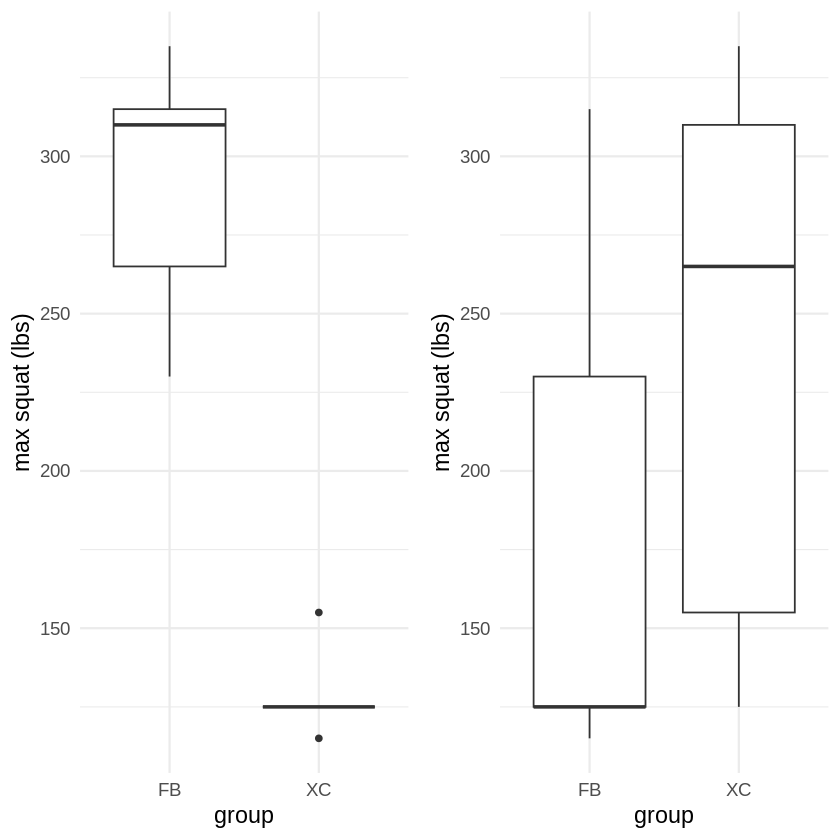

In [7]:
p1 <- ggplot(squatDf,aes(x=group,y=squat)) +
  geom_boxplot() +
  ylab('max squat (lbs)')

# create a scrambled version of the group membership variable


p2 <- ggplot(squatDf,aes(x=group,y=shuffledSquat)) +
  geom_boxplot() +
  ylab('max squat (lbs)')

plot_grid(p1, p2)

## Two-group t-test:

In [8]:
# compute and print t statistic comparing two groups

tt <-
  t.test(
    squat ~ group,
    data = squatDf,
    alternative = "greater"
  )
print(tt)


	Welch Two Sample t-test

data:  squat by group
t = 8.0055, df = 4.9964, p-value = 0.0002465
alternative hypothesis: true difference in means between group FB and group XC is greater than 0
95 percent confidence interval:
 121.2168      Inf
sample estimates:
mean in group FB mean in group XC 
             291              129 



## Figure 9.5

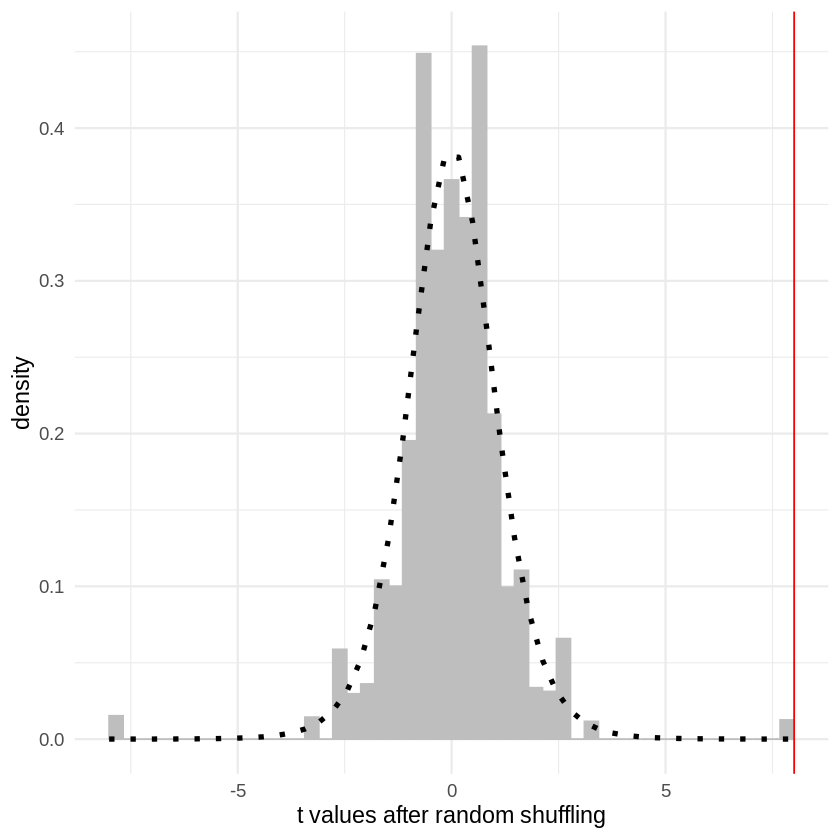

In [9]:
# shuffle data 10,000 times and compute distribution of t values

nRuns <- 10000

shuffleAndMeasure <- function(df) {
  dfScram <-
    df %>%
    mutate(
      squat = sample(squat)
    )
  tt <- t.test(
    squat ~ group,
    data = dfScram,
    alternative = "greater",
    var.equal = TRUE
  )
  return(tt$statistic)
}

shuffleDiff <- replicate(nRuns, shuffleAndMeasure(squatDf))

# compute p value using randomization
pvalRandomization <- mean(shuffleDiff >= tt$statistic)


ggplot(data.frame(shuffleDiff),aes(shuffleDiff)) +
  geom_histogram(aes(y=after_stat(density)),bins=50, color='gray', fill='gray') +
  geom_vline(xintercept = tt$statistic,color='red') +
  xlab('t values after random shuffling') +
  stat_function(fun = dt, args = list(df = 8),n = 50,linewidth=1.5,linetype='dotted')

## Figure 9.6

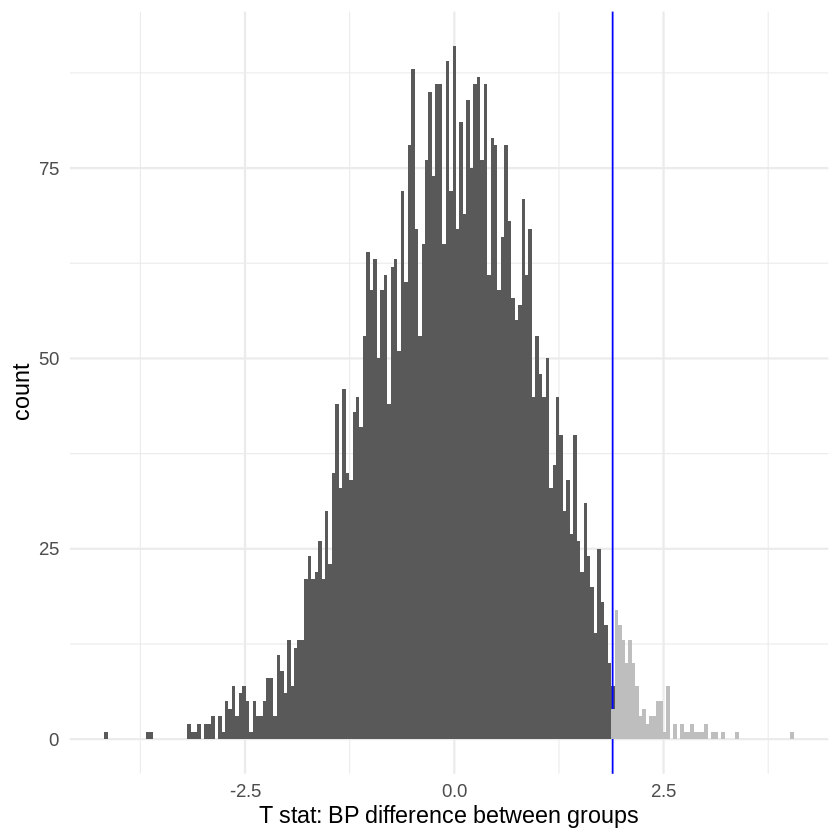

In [10]:
# create function to shuffle BP data

shuffleBPstat <- function() {
  bpDataShuffled <-
    NHANES_sample %>%
    select(BPSysAve, PhysActive) %>%
    mutate(
      BPSysAve = sample(BPSysAve)
    )
  # compute the difference
  simResult <- t.test(
    BPSysAve ~ PhysActive,
    data = bpDataShuffled,
  )
  return(simResult$statistic)
}

# run function 5000 times and save output

nRuns <- 5000
meanDiffSimDf <-
  data.frame(
    meanDiffSim = replicate(nRuns, shuffleBPstat())
  )

# compute the empirical probability of t values larger than observed
# value under the randomization null
bpTTest <-
  t.test(
  BPSysAve ~ PhysActive,
  data = NHANES_sample,
  alternative = "greater"
)

bpPvalRand <-
  mean(meanDiffSimDf$meanDiffSim >= bpTTest$statistic)

meanDiffSimDf %>%
  ggplot(aes(meanDiffSim)) +
  geom_histogram(bins = 200) +
  geom_vline(xintercept = bpTTest$statistic, color = "blue") +
  xlab("T stat: BP difference between groups") +
  geom_histogram(
    data = meanDiffSimDf %>%
      filter(meanDiffSim >= bpTTest$statistic),
    aes(meanDiffSim),
    bins = 200,
    fill = "gray"
  )

## Figure 9.7

Warning message:
“The `x` argument of `as_tibble.matrix()` must have unique column names if
`.name_repair` is omitted as of tibble 2.0.0.
ℹ Using compatibility `.name_repair`.”
Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


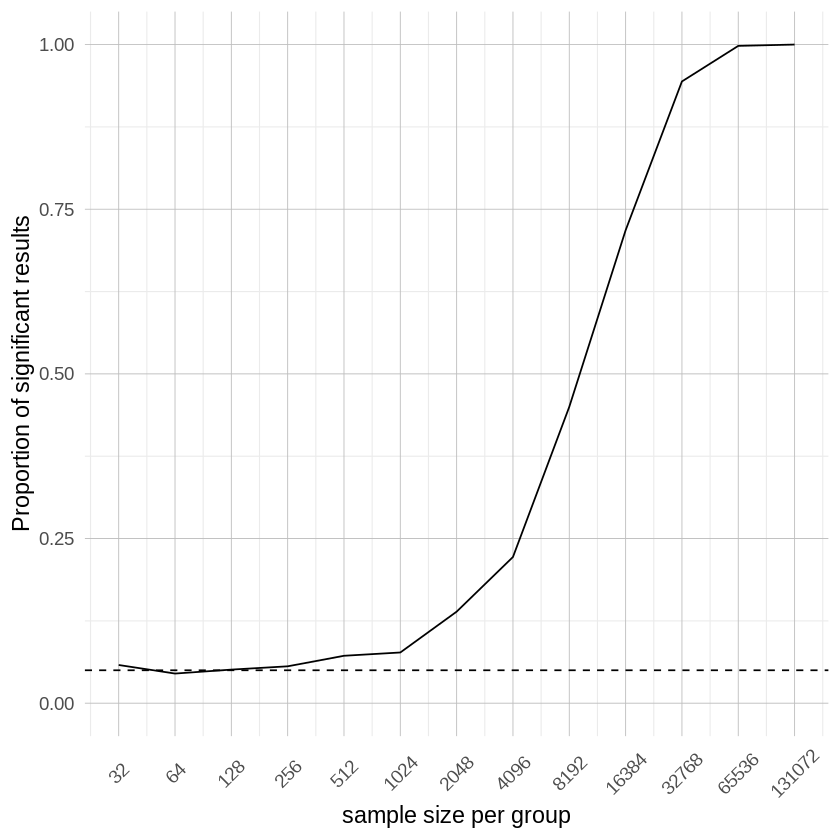

In [11]:
# create simulated data for BP reduction trial

exerciseTrial <- function(nPerGroup, bpReduction = 1) {
  # mean and SD on NHANES adult dataset
  bp_mean <- mean(NHANES$BPSysAve, na.rm=TRUE)
  bp_sd <- sd(NHANES$BPSysAve, na.rm=TRUE)
  # create data
  controlGroup <- rnorm(nPerGroup) * bp_sd + bp_mean
  expGroup <- rnorm(nPerGroup) * bp_sd + bp_mean - bpReduction
  ttResult <- t.test(expGroup, controlGroup)
  return(c(
    nPerGroup, bpReduction, ttResult$p.value,
    diff(ttResult$estimate)
  ))
}

nRuns <- 1000
sampSizes <- 2**seq(5,17) # powers of 2

simResults <- c() ## create an empty list to add results onto
for (i in 1:length(sampSizes)) {
  tmpResults <- replicate(
    nRuns,
    exerciseTrial(sampSizes[i], bpReduction = .5)
  )
  summaryResults <- c(
    tmpResults[1, 1], tmpResults[2, 1],
    sum(tmpResults[3, ] < 0.05),
    mean(tmpResults[4, ])
  )
  simResults <- rbind(simResults, summaryResults)
}


simResultsDf <-
  as_tibble(simResults) %>%
  rename(
    sampleSize = V1,
    effectSizeLbs = V2,
    nSigResults = V3,
    meanEffect = V4
  ) %>%
  mutate(pSigResult = nSigResults / nRuns)

ggplot(simResultsDf,aes(sampleSize,pSigResult)) +
  geom_line() +
  scale_x_continuous(trans='log2',breaks=simResultsDf$sampleSize) +
  theme(axis.text.x = element_text( angle=45,vjust=0.5)) +
  ylim(0,1) + ylab('Proportion of significant results') +
  xlab('sample size per group') +
  theme(panel.grid.major =   element_line(colour = "gray",linewidth=0.25)) +
  geom_hline(yintercept = 0.05,linetype='dashed')

## Figure 9.8

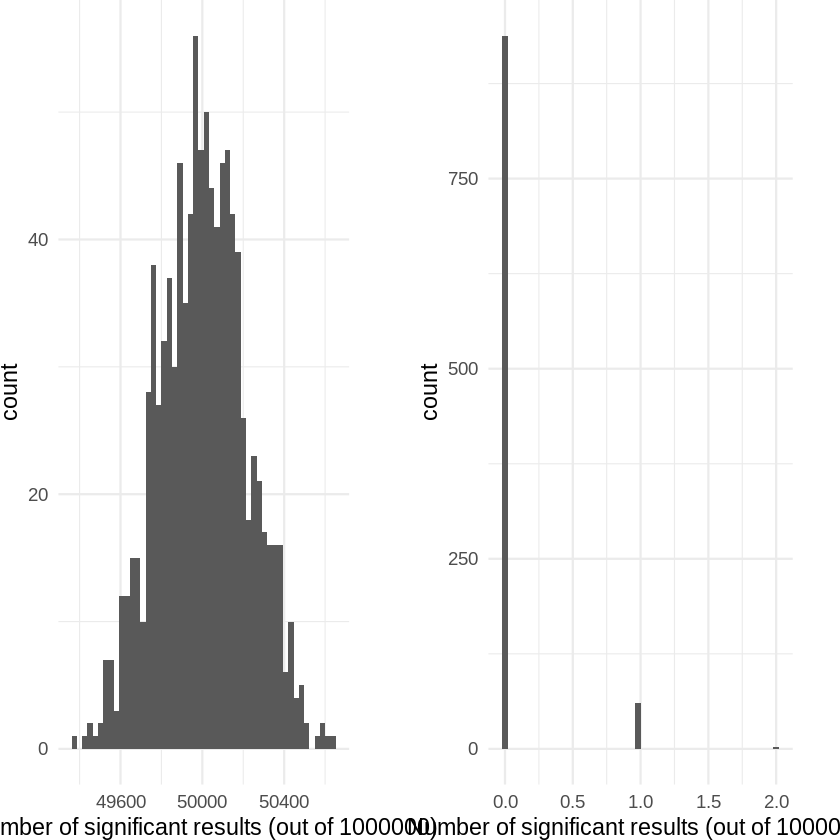

In [12]:
set.seed(5)
# simulate 1500 studies with 10,000 tests each, thresholded at p < .05

nRuns <- 1000 # number of simulated studies to run
nTests <- 1000000 # number of simulated genes to test in each run

uncAlpha <- 0.05 # alpha level

uncOutcome <- replicate(nRuns, sum(rnorm(nTests) < qnorm(uncAlpha)))

#sprintf("mean proportion of significant tests per run: %0.2f", mean(uncOutcome) / nTests)

# compute proportion of studies with at least one false positive result,
# known as the familywise error rate
#sprintf("familywise error rate: %0.3f", mean(uncOutcome > 0))

# compute Bonferroni-corrected alpha
corAlpha <- 0.05 / nTests

corOutcome <- replicate(nRuns, sum(rnorm(nTests) < (qnorm(corAlpha))))

# sprintf("corrected familywise error rate: %0.3f", mean(corOutcome > 0))

p1 <- data.frame(nsig=uncOutcome) %>%
  ggplot(aes(nsig)) +
  geom_histogram(bins=50) +
  xlab(sprintf('Number of significant results (out of %d)',nTests)) +
  theme(plot.margin = unit(c(0,1.5,0,0), "cm"))

p2 <- ggplot(data.frame(nsig=corOutcome),aes(nsig)) +
  geom_histogram(bins=50) +
  xlab(sprintf('Number of significant results (out of %d)',nTests)) +
  theme(plot.margin = unit(c(0,1,0,0), "cm"))

plot_grid(p1, p2)